<a href="https://colab.research.google.com/github/janmejaybhoi/Neural_Machine_Translation_LSTM_Attention_Eng-to-Bengali/blob/main/NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=center>NMT</h1>

In [393]:
import re
import string
import numpy as np
import pandas as pd
import pickle as pkl
from string import digits
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed

In [394]:
from attention import AttentionLayer

In [395]:
with open('ben.txt','r') as f:
  data = f.read()

In [396]:
uncleaned_data_list = data.split('\n')

In [397]:
len(uncleaned_data_list)

4343

In [398]:
uncleaned_data_list = uncleaned_data_list[:4342]

In [399]:
len(uncleaned_data_list)

4342

In [400]:
english_word = []
Bengali_word = []
cleaned_data_list = []
for word in uncleaned_data_list:
  english_word.append(word.split('\t')[:-1][0])
  Bengali_word.append(word.split('\t')[:-1][1])

In [401]:
len(english_word), len(marathi_word)


(4342, 4342)

In [402]:
language_data = pd.DataFrame(columns=['English','Bengali'])
language_data['English'] = english_word
language_data['Bengali'] = Bengali_word

In [403]:
language_data.to_csv('language_data.csv', index=False)


In [404]:
language_data = pd.read_csv('language_data.csv')


In [405]:
language_data.head()


,English,Bengali
0,Go.,যাও।
1,Go.,যান।
2,Go.,যা।
3,Run!,পালাও!
4,Run!,পালান!


In [406]:
english_text = language_data['English'].values
Bengali_text = language_data['Bengali'].values

In [407]:
english_text[0], Bengali_text[0]


('Go.', 'যাও।')

In [408]:
len(english_text), len(Bengali_text)


(4342, 4342)

In [409]:
english_text_ = [x.lower() for x in english_text]
Bengali_text_ = [x.lower() for x in Bengali_text]

In [410]:
english_text_ = [re.sub("'",'',x) for x in english_text_]
Bengali_text_ = [re.sub("'",'',x) for x in Bengali_text_]

In [411]:
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
Bengali_text_ = remove_punc(Bengali_text_)

In [412]:
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text

# removing the digits from the Bengali sentances
Bengali_text_ = [re.sub("[৭০১২৩৪৫৬৭৮৯]","",x) for x in Bengali_text_]
Bengali_text_ = [re.sub("[\u200d]","",x) for x in Bengali_text_]

# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
Bengali_text_ = [x.strip() for x in Bengali_text_]

In [413]:
# removing the starting and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
Bengali_text_ = [x.strip() for x in Bengali_text_]

In [414]:
# Putting the start and end words in the Bengali sentances
Bengali_text_ = ["start " + x + " end" for x in Bengali_text_]

In [415]:
Bengali_text_[0], english_text_[0]

('start যাও। end', 'go')

In [416]:
# manipulated_marathi_text_
Bengali_text_[0], english_text_[0]

('start যাও। end', 'go')

In [417]:

X = english_text_
Y = Bengali_text_

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(3907, 3907, 435, 435)

In [419]:

X_train[0], y_train[0]

('i want time', 'start আমার সময় চাই। end')

In [420]:

def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_english = Max_length(X_train)
max_length_Bengali = Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_length_Bengali_test = Max_length(y_test)

In [421]:
max_length_Bengali, max_length_english


(20, 19)

In [422]:
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')

X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')


In [423]:
BengaliTokenizer = Tokenizer()
BengaliTokenizer.fit_on_texts(y_train)
Bword2index = BengaliTokenizer.word_index
vocab_size_target = len(Bword2index) + 1

y_train = BengaliTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_Bengali, padding='post')

y_test = BengaliTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_Bengali, padding='post')


In [424]:
vocab_size_source, vocab_size_target

(1778, 3132)

In [425]:
with open('NMT_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f)


In [426]:
with open('NMT_Etokenizer.pkl','wb') as f:
  pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)

with open('NMT_Btokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, Bword2index, BengaliTokenizer], f)

In [427]:
X_train[0], y_train[0]

(array([ 1, 19, 40,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], dtype=int32),
 array([ 1,  5, 34, 42,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], dtype=int32))

In [428]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [429]:
X_train[0], y_train[0]

(array([ 1, 19, 40,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], dtype=int32),
 array([ 1,  5, 34, 42,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], dtype=int32))

In [430]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_length_english,)) 
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 19, 500)      889000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 19, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

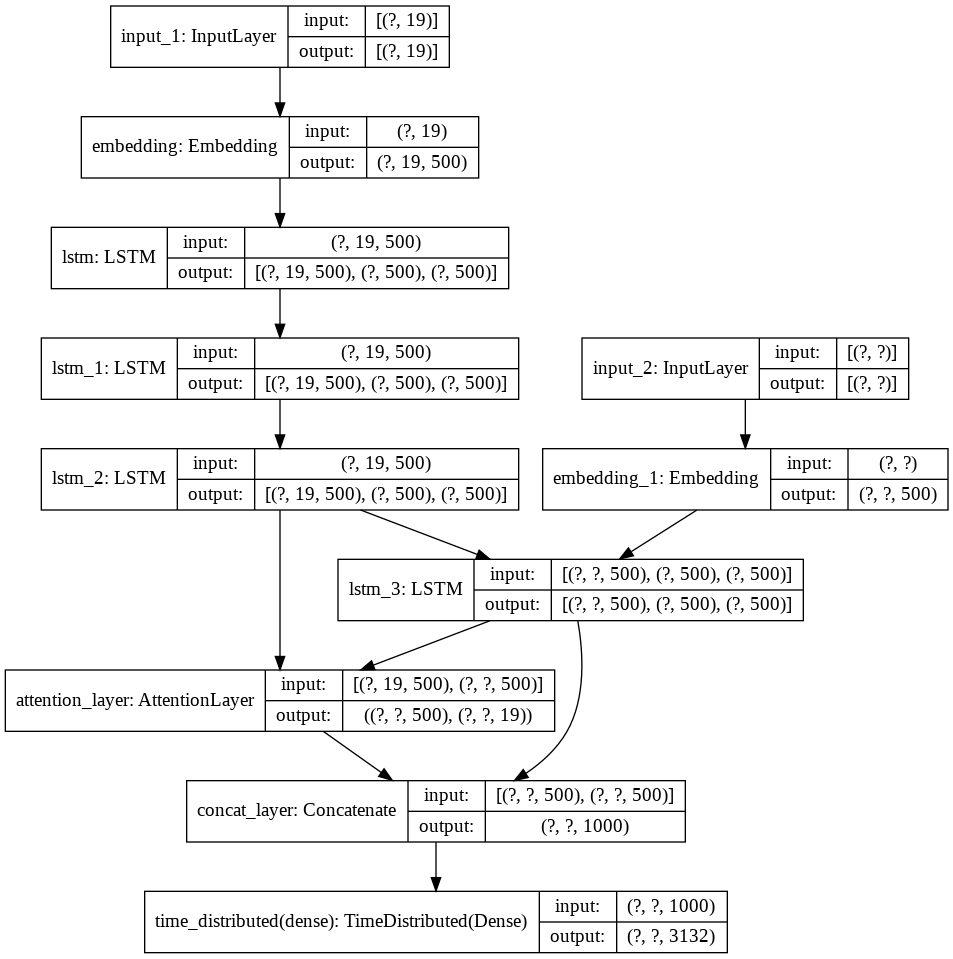

In [431]:
plot_model(model, to_file='train_model.png', show_shapes=True)


In [432]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [433]:
es = EarlyStopping(monitor='val_loss', mode='min',patience= 5, verbose=1)

In [434]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=50, 
                    callbacks=[es],
                    batch_size=64,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
62/62 [==============================] - 6s 101ms/step - loss: 1.9925 - accuracy: 0.7359 - val_loss: 1.4177 - val_accuracy: 0.7985
Epoch 2/50
62/62 [==============================] - 5s 80ms/step - loss: 1.4873 - accuracy: 0.7857 - val_loss: 1.3225 - val_accuracy: 0.8025
Epoch 3/50
62/62 [==============================] - 5s 81ms/step - loss: 1.3609 - accuracy: 0.7912 - val_loss: 1.2681 - val_accuracy: 0.8038
Epoch 4/50
62/62 [==============================] - 5s 80ms/step - loss: 1.2421 - accuracy: 0.8000 - val_loss: 1.1592 - val_accuracy: 0.8129
Epoch 5/50
62/62 [==============================] - 5s 79ms/step - loss: 1.1232 - accuracy: 0.8115 - val_loss: 1.1208 - val_accuracy: 0.8188
Epoch 6/50
62/62 [==============================] - 5s 80ms/step - loss: 1.0115 - accuracy: 0.8234 - val_loss: 1.0488 - val_accuracy: 0.8241
Epoch 7/50
62/62 [==============================] - 5s 80ms/step - loss: 0.9006 - accuracy: 0.8335 - val_loss: 0.9926 - val_accuracy: 0.8364
Epoch 8/50
6

In [435]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [436]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

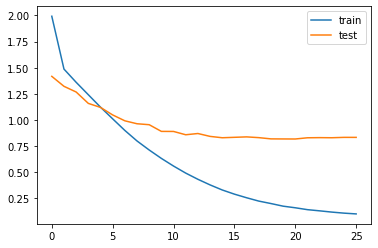

In [437]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

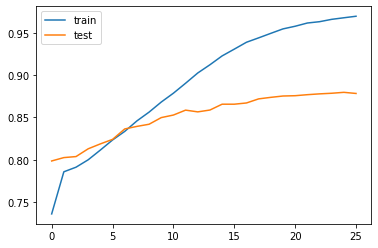

In [438]:
pyplot.plot(history.history['accuracy'], label='train') 
pyplot.plot(history.history['val_accuracy'], label='test') 
pyplot.legend() 
pyplot.show()

In [439]:
with open('NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, englishTokenizer = pkl.load(f)

with open('NMT_Btokenizer.pkl', 'rb') as f:
  vocab_size_target, Bword2index, BengaliTokenizer = pkl.load(f)

with open('NMT_data.pkl','rb') as f:
  X_train, y_train, X_test, y_test = pkl.load(f)

In [440]:
Eindex2word = englishTokenizer.index_word
Bindex2word = BengaliTokenizer.index_word

In [441]:
# model_loaded.summary()

In [442]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs

print(encoder_outputs.shape)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(32,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]

dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

(None, 19, 500)
(None, None)


In [443]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Bword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Bindex2word[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c

    return decoded_sentence

In [444]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Bword2index['start']) and i!=Bword2index['end']):
        newString=newString+Bindex2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

In [447]:
for i in range(20):
  
  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,19)))
  print("\n")

Review: what happened here 
Original summary: এখানে কি হয়েছে 
Predicted summary:  মৌমাছিরা কী খায়


Review: tom is in now 
Original summary: টম এখন 
Predicted summary:  টম এখানে থাকে।


Review: i want to get off at the next stop 
Original summary: আমি পরের স্টপে চাই। 
Predicted summary:  আমি এই ট্রেনে একটা আসন সংরক্ষণ করতে চাই।


Review: thats what i was looking for 
Original summary: আমি এইটাই 
Predicted summary:  আমি চায়না স্টেশনে কিভাবে যাব


Review: tom started in french 
Original summary: টম ফরাসিতে দেওয়া শুরু করলো। 
Predicted summary:  টম ওনার কথা রাখেন।


Review: i dont know what you mean 
Original summary: আমি জানিনা তুমি কি বোঝাতে 
Predicted summary:  আমি জানিনা আপনি কি বোঝাতে চাইছেন।


Review: everybody tom 
Original summary: সবাই টমকে 
Predicted summary:  সবাই চিৎকার করলো।


Review: everythings negotiable 
Original summary: সবকিছুই আলোচনাসূত্রে মীমাংসাযোগ্য। 
Predicted summary:  সবকিছুই এখানে আছে।


Review: tom is coughing 
Original summary: টম 
Predicted summary:  টম ছা